**Import necessary libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xg
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA



**Loading data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/cs464group11/datas"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data_description.txt  sample_submission.csv  test.csv  train.csv


In [7]:
dataset_dir = '/content/drive/MyDrive/cs464group11/datas'
csv_path    = os.path.join(dataset_dir, 'train.csv')
data        = pd.read_csv(csv_path)


**Information about data**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Observing numerical features and categorical features**

In [9]:
numerical_feats   = data.dtypes[data.dtypes != "object"].index
categorical_feats = data.dtypes[data.dtypes == "object"].index

print("Number of Numerical features   :", len(numerical_feats))
print("Number of Categorical features :", len(categorical_feats))

Number of Numerical features   : 38
Number of Categorical features : 43


In [10]:
numeric_train = data.select_dtypes(include=[np.number])

In [11]:
cat_train     = data.select_dtypes(exclude=[np.number])

**Histogram of the sale prices**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


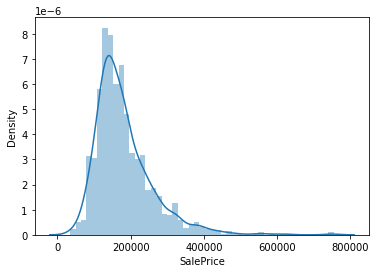

In [12]:
sns.distplot(data['SalePrice'])

**Checking for missing values in the dataset**

In [13]:
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_data.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

**Checking for missing values in the numerical data**

In [14]:
missing_data_num=data[numerical_feats].isnull().sum().sort_values(ascending=False)
missing_data_num.head(5)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
Id               0
OpenPorchSF      0
dtype: int64

**Checking for missing values in the categorical data**

In [15]:
missing_data_cat = data[categorical_feats].isnull().sum().sort_values(ascending=False)
missing_data_cat.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageType        81
GarageCond        81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
Electrical         1
Functional         0
KitchenQual        0
CentralAir         0
HeatingQC          0
dtype: int64

**Filling missing values according to data types**

In [16]:
imp = IterativeImputer(random_state=42)
for col in data:
    if data[col].dtype == "object":
        data[col].fillna("None", inplace=True)
    if data[col].dtype == "int":
        data[col].fillna(data[col].mean(), inplace=True)
    if data[col].dtype == 'float':
        data[col] = imp.fit_transform(data[col].values.reshape(-1,1))

**One Hot Encoding to transform categorical data**

In [17]:
data = pd.get_dummies(data, columns = 
['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour',
'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
'Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish',
'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
'SaleType','SaleCondition','PavedDrive'])


**Heatmap visualization of the correlation among features**

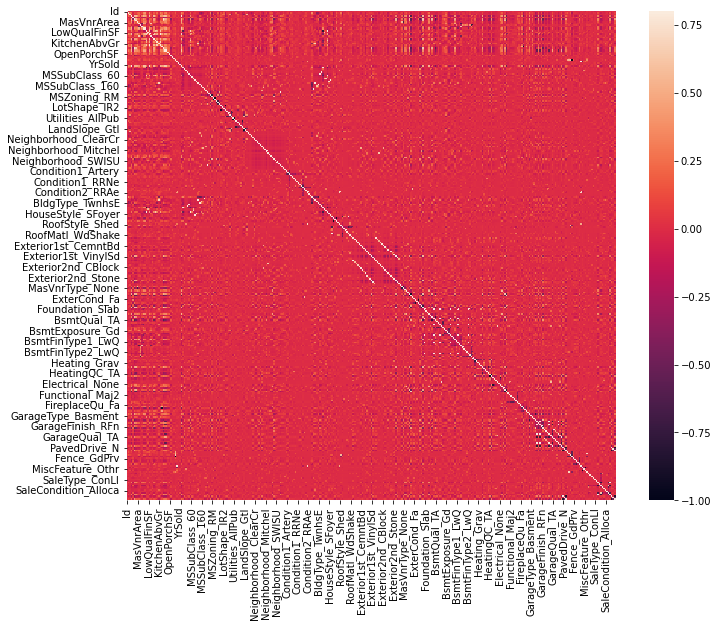

In [18]:
correlation1 = data.corr()
f, ax        = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation1, vmax=0.8, square=True)

**Observing highly correlated features**

In [19]:
high_feature_columns = correlation1['SalePrice'][correlation1['SalePrice'].values > 0.2].index.values

****Observing insignificant features****

In [20]:
unnec_feature_columns = correlation1['SalePrice'][correlation1['SalePrice'].values < 0.3].index.values

**Removing insignificant features**

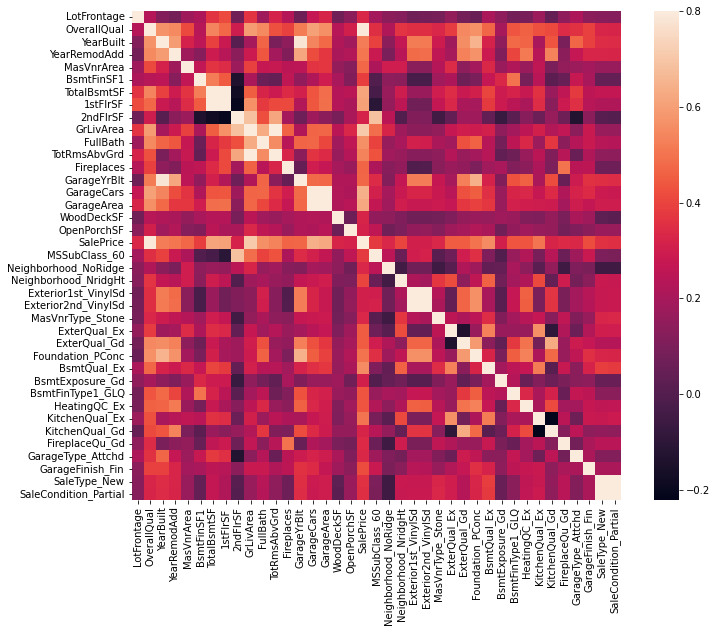

In [21]:
train_reduced = data.drop(unnec_feature_columns, axis=1)
correlation2  = train_reduced.corr()
f, ax         = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation2, vmax=0.8, square=True)

**Removing highly correlated features**

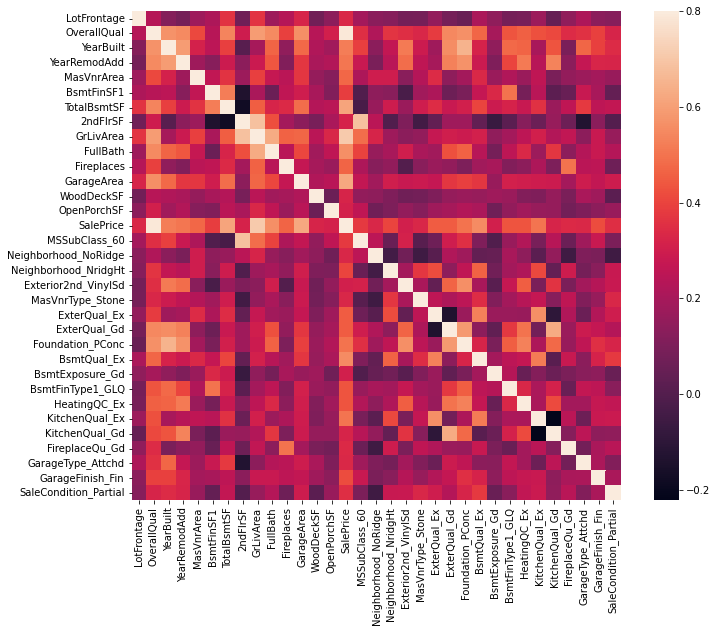

In [22]:
train_reduced2 = train_reduced.drop(['SaleType_New','Exterior1st_VinylSd','GarageCars','1stFlrSF','GarageYrBlt','TotRmsAbvGrd'], axis=1)
correlation3   = train_reduced2.corr()
f, ax          = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation3, vmax=0.8, square=True)

**Splitting dataset into x(features) and y(price)** 


In [23]:
x = train_reduced2.drop('SalePrice', axis =1)
y = train_reduced2['SalePrice']

**Removing outlier entities from data**

In [ ]:
y  = y[y < 700000]
x  = x.drop([691, 1182])

**Splitting dataset into train and test**

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# **Deep Learning Model**

**Multilayer Perceptron Model**

5/5 [==============================] - 0s 3ms/step


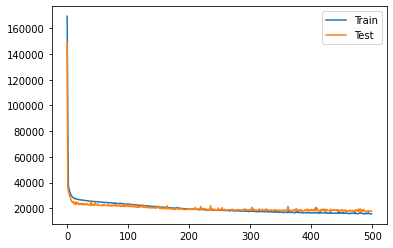

MLP Mean Absolute Error: 17753.73464255137


In [25]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1  , activation='linear')
])

model.compile(
    loss= tf.keras.losses.mae,
    optimizer=Adam(),
    metrics=['mae']
)

history     = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs=500, verbose = 0)
predictions = model.predict(X_test)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

print('MLP Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))

# **Regression Models**

**Linear Regression**

In [26]:
LinearRegressor  = LinearRegression().fit(X_train, y_train)
LRprediction     = LinearRegressor.predict(X_test)

print("Linear Regression (Train) {}\u00b2 :".format("R"),LinearRegressor.score(X_train, y_train))
print("Linear Regression (Test)  {}\u00b2 :".format("R"),LinearRegressor.score(X_test, y_test))
print("")
print('Linear Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, LRprediction))
print('Linear Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, LRprediction))
print('Linear Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, LRprediction)))

Linear Regression (Train) R² : 0.8331088387240573
Linear Regression (Test)  R² : 0.8708690993692374

Linear Regression Mean Absolute Error     : 19061.38822903275
Linear Regression Mean Squared Error      : 677249148.72916
Linear Regression Root Mean Squared Error : 26024.011003862568


In [79]:
pd.DataFrame({'Actual':y_test, 'Predicted (LR)':LRprediction})

,Actual,Predicted (LR)
1322,190000,206932.098120
837,100000,106307.156058
413,115000,123612.567827
522,159000,172525.581262
1036,315500,259508.275134
...,...,...
526,132000,123391.658094
101,178000,194352.022641
883,118500,192325.921615
411,145000,172527.822840


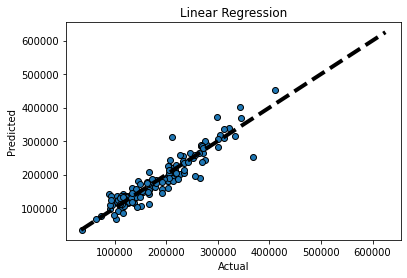

In [28]:
fig, ax = plt.subplots()
ax.scatter(LRprediction,y_test, edgecolors = (0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Linear Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()


**Ridge Regression**

In [29]:
RidgeRegression = Ridge(alpha=0.01).fit(X_train, y_train)
RRprediction    = RidgeRegression.predict(X_test)

print("Ridge Regression (Train) {}\u00b2 :".format("R"),RidgeRegression.score(X_train, y_train))
print("Ridge Regression (Test)  {}\u00b2 :".format("R"),RidgeRegression.score(X_test, y_test))
print("")
print('Ridge Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, RRprediction))
print('Ridge Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, RRprediction))
print('Ridge Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, RRprediction)))


Ridge Regression (Train) R² : 0.8331088370214879
Ridge Regression (Test)  R² : 0.8708722796166843

Ridge Regression Mean Absolute Error     : 19061.084555954658
Ridge Regression Mean Squared Error      : 677232469.3761497
Ridge Regression Root Mean Squared Error : 26023.690541046435


In [30]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (RR)': RRprediction})

,Actual,Predicted
0,190000,264964.640654
1,100000,114431.289076
2,115000,112882.249294
3,159000,169184.081046
4,315500,333337.801462
...,...,...
141,132000,115771.689590
142,178000,190977.229842
143,118500,134511.331388
144,145000,133355.600216


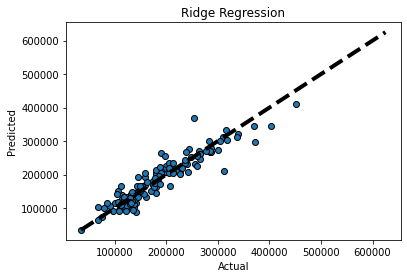

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_test, RRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Ridge Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

**KNeighbors Regression**

In [32]:
KNeighborsRegression = KNeighborsRegressor(n_neighbors=19).fit(X_train, y_train)
KNRprediction        = KNeighborsRegression.predict(X_test)
 
print("KNeighbors Regression (Train) {}\u00b2 :".format("R"),KNeighborsRegression.score(X_train, y_train))
print("KNeighbors Regression (Test)  {}\u00b2 :".format("R"),KNeighborsRegression.score(X_test, y_test))
print("")
print('KNeighbors Regressor Mean Absolute Error     :', metrics.mean_absolute_error(y_test, KNRprediction))
print('KNeighbors Regressor Mean Squared Error      :', metrics.mean_squared_error(y_test, KNRprediction))
print('KNeighbors Regressor Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, KNRprediction)))

KNeighbors Regression (Train) R² : 0.7707577442326533
KNeighbors Regression (Test)  R² : 0.7811846625913583

KNeighbors Regressor Mean Absolute Error     : 23234.199711607787
KNeighbors Regressor Mean Squared Error      : 1147614554.4173717
KNeighbors Regressor Root Mean Squared Error : 33876.46018133199


In [80]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (KNR)': KNRprediction})

,Actual,Predicted (KNR)
0,190000,210885.684211
1,100000,101957.894737
2,115000,117817.368421
3,159000,155052.631579
4,315500,280022.789474
...,...,...
141,132000,125676.315789
142,178000,176810.526316
143,118500,162259.210526
144,145000,149724.210526


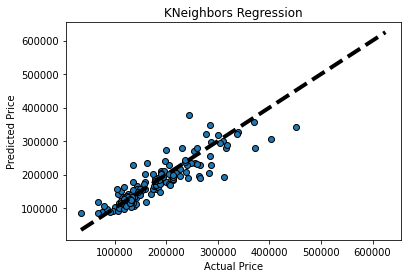

In [34]:
fig, ax = plt.subplots()
ax.scatter(y_test, KNRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('KNeighbors Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

**Extra Trees Regression**

In [35]:
ExtraTreesRegression = ExtraTreesRegressor(ccp_alpha=0, criterion='absolute_error', max_features='auto', n_estimators=500, random_state=42).fit(X_train, y_train)
ETprediction         = ExtraTreesRegression.predict(X_test)

print("Extra Trees Regression (Train) {}\u00b2 :".format("R"),ExtraTreesRegression.score(X_train, y_train))
print("Extra Trees Regression (Test)  {}\u00b2 :".format("R"),ExtraTreesRegression.score(X_test, y_test))
print("")
print('Extra Trees Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, ETprediction))
print('Extra Trees Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, ETprediction))
print('Extra Trees Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, ETprediction)))

Extra Trees Regression (Train) R² : 0.9999638886820608
Extra Trees Regression (Test)  R² : 0.8691956732261384

Extra Trees Regression Mean Absolute Error     : 17497.950849315068
Extra Trees Regression Mean Squared Error      : 686025719.056936
Extra Trees Regression Root Mean Squared Error : 26192.092681894206


In [36]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (ETR)': ETprediction})

,Actual,Predicted
0,190000,255924.066
1,100000,89460.600
2,115000,114793.202
3,159000,163511.428
4,315500,355470.506
...,...,...
141,132000,128189.900
142,178000,184694.448
143,118500,157794.206
144,145000,135695.550


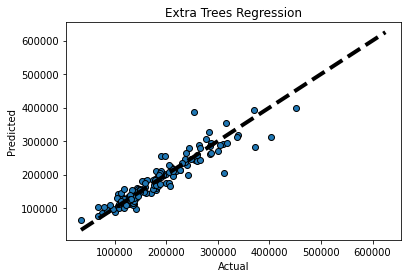

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_test, ETprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Extra Trees Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

**Random Forest Regression**

In [38]:
RandomForestRegression  = RandomForestRegressor(n_estimators=66,random_state=0,max_depth=10).fit(X_train,y_train)
RFprediction            = RandomForestRegression.predict(X_test)

print("Random Forest Regression (Train) {}\u00b2 :".format("R"),RandomForestRegression.score(X_train, y_train))
print("Random Forest Regression (Test)  {}\u00b2 :".format("R"),RandomForestRegression.score(X_test, y_test))
print("")
print('Random Forest Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, RFprediction))
print('Random Forest Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, RFprediction))
print('Random Forest Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, RFprediction)))

Random Forest Regression (Train) R² : 0.9709934528375168
Random Forest Regression (Test)  R² : 0.8820068635325734

Random Forest Regression Mean Absolute Error     : 16934.17930663465
Random Forest Regression Mean Squared Error      : 618835234.9291315
Random Forest Regression Root Mean Squared Error : 24876.399155205952


In [39]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (RFR)': RFprediction})

,Actual,Predicted
0,190000,213720.244551
1,100000,90836.377975
2,115000,111043.778473
3,159000,158256.320065
4,315500,316645.595039
...,...,...
141,132000,125155.534395
142,178000,177795.184257
143,118500,120467.207815
144,145000,133667.092656


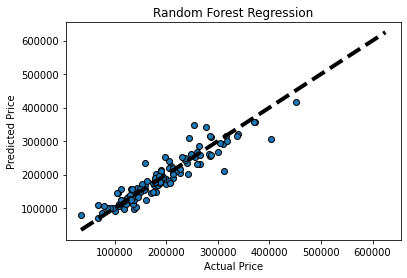

In [40]:
fig, ax = plt.subplots()
ax.scatter(y_test, RFprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Random Forest Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

In [41]:
XGBRegression = xg.XGBRegressor(eval_metric='mae',n_estimators = 40, objective = 'reg:squarederror',seed = 123).fit(X_train, y_train)
XGBRprediction = XGBRegression.predict(X_test)

print("XGBoost Regression (Train) {}\u00b2 :".format("R"),XGBRegression.score(X_train, y_train))
print("XGBoost Regression (Test)  {}\u00b2 :".format("R"),XGBRegression.score(X_test, y_test))
print("")
print('XGB Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, XGBRprediction))
print('XGB Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, XGBRprediction))
print('XGB Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, XGBRprediction)))

XGBoost Regression (Train) R² : 0.9229666373490939
XGBoost Regression (Test)  R² : 0.8946350118653541

XGB Regression Mean Absolute Error     : 16062.90962114726
XGB Regression Mean Squared Error      : 552604745.8159477
XGB Regression Root Mean Squared Error : 23507.5465716001


**XGBoost Regression**

In [42]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (XGBR)': XGBRprediction})

,Actual,Predicted
0,190000,210193.390625
1,100000,107026.460938
2,115000,114350.031250
3,159000,158920.265625
4,315500,319961.906250
...,...,...
141,132000,128096.242188
142,178000,173998.750000
143,118500,117932.945312
144,145000,136984.625000


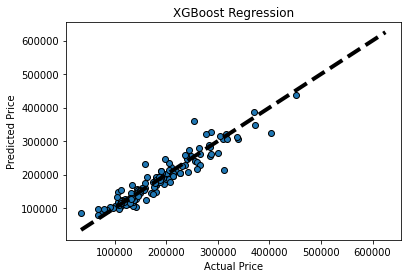

In [43]:
fig, ax = plt.subplots()
ax.scatter(y_test, XGBRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('XGBoost Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

**Voting Regressor**

In [44]:
VotingRegression = VotingRegressor(estimators=[('LR', LinearRegressor),("XGBR",XGBRegression),("RF",RandomForestRegression)]).fit(X_train, y_train)
VRprediction     = VotingRegression.predict(X_test)

print("Voting Regression (Train) {}\u00b2 :".format("R"),VotingRegression.score(X_train, y_train))
print("Voting Regression (Test)  {}\u00b2 :".format("R"),VotingRegression.score(X_test, y_test))
print("")
print('Voting Regressor Mean Absolute Error     :', metrics.mean_absolute_error(y_test, VRprediction))
print('Voting Regressor Mean Squared Error      :', metrics.mean_squared_error(y_test, VRprediction))
print('Voting Regressor Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, VRprediction)))

Voting Regression (Train) R² : 0.9306193525580817
Voting Regression (Test)  R² : 0.8985301944260488

Voting Regressor Mean Absolute Error     : 15873.489928541514
Voting Regressor Mean Squared Error      : 532175793.02084374
Voting Regressor Root Mean Squared Error : 23068.935671609208


In [45]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted (VR)': VRprediction})

,Actual,Predicted
0,190000,229631.539978
1,100000,104097.921110
2,115000,112758.982790
3,159000,162120.216345
4,315500,323316.133387
...,...,...
141,132000,123007.802936
142,178000,180923.791300
143,118500,124303.169585
144,145000,134668.954275


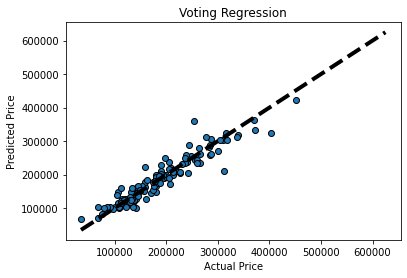

In [46]:
fig, ax = plt.subplots()
ax.scatter(y_test, VRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Voting Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

# **PCA for feature selection**

**Applying PCA for 99% explained variance**

In [47]:
pca = PCA(0.99)
pca.fit(X_train)

**Observe number of components**

In [49]:
pca.n_components_

7

**Transform data**

In [50]:
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

In [81]:
print("Train data shape : ",X_train.shape)
print("Test  data shape : ",X_test.shape)

Train data shape :  (1312, 7)
Test  data shape :  (146, 7)


# **Training same models with transformed data and observing the error**

**Multilayer Perceptron Model**

5/5 [==============================] - 0s 3ms/step


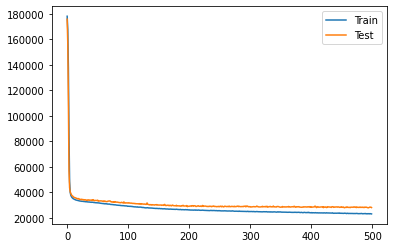

MLP Mean Absolute Error: 28152.467465753423


In [52]:
tf.random.set_seed(42)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1  , activation='linear')
])

model.compile(
    loss= tf.keras.losses.mae,
    optimizer=Adam(),
    metrics=['mae']
)

history     = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32,epochs=500, verbose = 0)
predictions = model.predict(X_test)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

print('MLP Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))

**Regression Models**

In [53]:
LinearRegressor  = LinearRegression().fit(X_train, y_train)
LRprediction     = LinearRegressor.predict(X_test)

print("Linear Regression (Train) {}\u00b2 :".format("R"),LinearRegressor.score(X_train, y_train))
print("Linear Regression (Test)  {}\u00b2 :".format("R"),LinearRegressor.score(X_test, y_test))
print("")
print('Linear Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, LRprediction))
print('Linear Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, LRprediction))
print('Linear Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, LRprediction)))

Linear Regression (Train) R² : 0.6693806592203493
Linear Regression (Test)  R² : 0.7837730162743431

Linear Regression Mean Absolute Error     : 23992.606940722028
Linear Regression Mean Squared Error      : 1134039489.7361157
Linear Regression Root Mean Squared Error : 33675.50281341194


In [54]:
pd.DataFrame({'Actual':y_test, 'Predicted':LRprediction})

,Actual,Predicted
1322,190000,206932.098120
837,100000,106307.156058
413,115000,123612.567827
522,159000,172525.581262
1036,315500,259508.275134
...,...,...
526,132000,123391.658094
101,178000,194352.022641
883,118500,192325.921615
411,145000,172527.822840


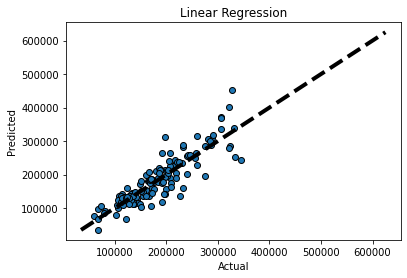

In [55]:
fig, ax = plt.subplots()
ax.scatter(LRprediction,y_test, edgecolors = (0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Linear Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()


In [56]:
RidgeRegression = Ridge(alpha=0.01).fit(X_train, y_train)
RRprediction    = RidgeRegression.predict(X_test)

print("Ridge Regression (Train) {}\u00b2 :".format("R"),RidgeRegression.score(X_train, y_train))
print("Ridge Regression (Test)  {}\u00b2 :".format("R"),RidgeRegression.score(X_test, y_test))
print("")
print('Ridge Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, RRprediction))
print('Ridge Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, RRprediction))
print('Ridge Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, RRprediction)))


Ridge Regression (Train) R² : 0.6693806592203493
Ridge Regression (Test)  R² : 0.7837730162713051

Ridge Regression Mean Absolute Error     : 23992.60694077065
Ridge Regression Mean Squared Error      : 1134039489.7520492
Ridge Regression Root Mean Squared Error : 33675.50281364852


In [57]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': RRprediction})

,Actual,Predicted
0,190000,206932.098117
1,100000,106307.156060
2,115000,123612.567829
3,159000,172525.581266
4,315500,259508.275126
...,...,...
141,132000,123391.658092
142,178000,194352.022635
143,118500,192325.921619
144,145000,172527.822835


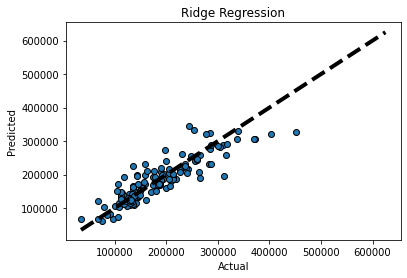

In [58]:
fig, ax = plt.subplots()
ax.scatter(y_test, RRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Ridge Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [59]:
KNeighborsRegression = KNeighborsRegressor(n_neighbors=19).fit(X_train, y_train)
KNRprediction        = KNeighborsRegression.predict(X_test)
 
print("KNeighbors Regression (Train) {}\u00b2 :".format("R"),KNeighborsRegression.score(X_train, y_train))
print("KNeighbors Regression (Test)  {}\u00b2 :".format("R"),KNeighborsRegression.score(X_test, y_test))
print("")
print('KNeighbors Regressor Mean Absolute Error     :', metrics.mean_absolute_error(y_test, KNRprediction))
print('KNeighbors Regressor Mean Squared Error      :', metrics.mean_squared_error(y_test, KNRprediction))
print('KNeighbors Regressor Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, KNRprediction)))

KNeighbors Regression (Train) R² : 0.7677590992393497
KNeighbors Regression (Test)  R² : 0.7767490742156766

KNeighbors Regressor Mean Absolute Error     : 23504.295962509015
KNeighbors Regressor Mean Squared Error      : 1170877758.1654274
KNeighbors Regressor Root Mean Squared Error : 34218.09109470351


In [60]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': KNRprediction})

,Actual,Predicted
0,190000,210885.684211
1,100000,101957.894737
2,115000,117817.368421
3,159000,155052.631579
4,315500,280022.789474
...,...,...
141,132000,125676.315789
142,178000,176810.526316
143,118500,162259.210526
144,145000,149724.210526


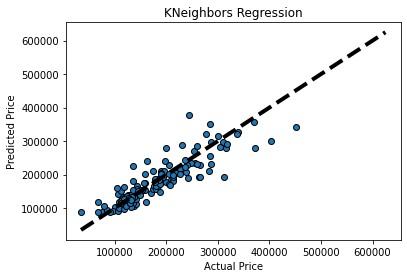

In [64]:
fig, ax = plt.subplots()
ax.scatter(y_test, KNRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('KNeighbors Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

In [65]:
ExtraTreesRegression = ExtraTreesRegressor(ccp_alpha=0, criterion='absolute_error', max_features='auto', n_estimators=500, random_state=42).fit(X_train, y_train)
ETprediction         = ExtraTreesRegression.predict(X_test)

print("Extra Trees Regression (Train) {}\u00b2 :".format("R"),ExtraTreesRegression.score(X_train, y_train))
print("Extra Trees Regression (Test)  {}\u00b2 :".format("R"),ExtraTreesRegression.score(X_test, y_test))
print("")
print('Extra Trees Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, ETprediction))
print('Extra Trees Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, ETprediction))
print('Extra Trees Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, ETprediction)))

Extra Trees Regression (Train) R² : 0.9999637663354216
Extra Trees Regression (Test)  R² : 0.7453737060666629

Extra Trees Regression Mean Absolute Error     : 23745.15528767123
Extra Trees Regression Mean Squared Error      : 1335431255.943182
Extra Trees Regression Root Mean Squared Error : 36543.552864262965


In [66]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': ETprediction})

,Actual,Predicted
0,190000,207959.004
1,100000,101260.200
2,115000,111564.440
3,159000,150169.094
4,315500,251964.794
...,...,...
141,132000,124080.010
142,178000,175249.892
143,118500,176646.412
144,145000,144620.374


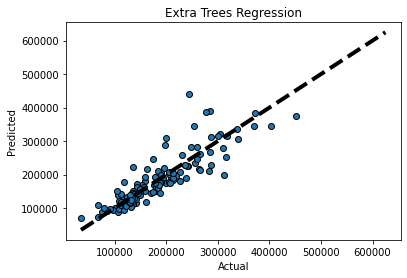

In [67]:
fig, ax = plt.subplots()
ax.scatter(y_test, ETprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Extra Trees Regression')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [68]:
RandomForestRegression  = RandomForestRegressor(n_estimators=66,random_state=0,max_depth=10).fit(X_train,y_train)
RFprediction            = RandomForestRegression.predict(X_test)

print("Random Forest Regression (Train) {}\u00b2 :".format("R"),RandomForestRegression.score(X_train, y_train))
print("Random Forest Regression (Test)  {}\u00b2 :".format("R"),RandomForestRegression.score(X_test, y_test))
print("")
print('Random Forest Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, RFprediction))
print('Random Forest Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, RFprediction))
print('Random Forest Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, RFprediction)))

Random Forest Regression (Train) R² : 0.9480829978978202
Random Forest Regression (Test)  R² : 0.772418760731091

Random Forest Regression Mean Absolute Error     : 22889.619807077994
Random Forest Regression Mean Squared Error      : 1193588829.6970346
Random Forest Regression Root Mean Squared Error : 34548.35494921624


In [69]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': RFprediction})

,Actual,Predicted
0,190000,200458.848056
1,100000,92278.139346
2,115000,107138.580924
3,159000,154518.042294
4,315500,260619.087691
...,...,...
141,132000,119066.160225
142,178000,175551.004924
143,118500,161839.665856
144,145000,148425.353557


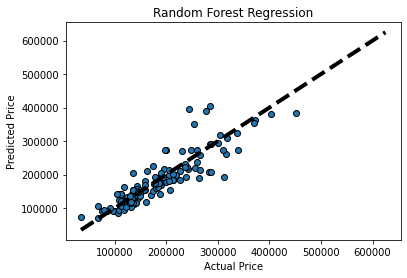

In [70]:
fig, ax = plt.subplots()
ax.scatter(y_test, RFprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Random Forest Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

In [71]:
XGBRegression = xg.XGBRegressor(eval_metric='mae',n_estimators = 40, objective = 'reg:squarederror',seed = 123).fit(X_train, y_train)
XGBRprediction = XGBRegression.predict(X_test)

print("XGBoost Regression (Train) {}\u00b2 :".format("R"),XGBRegression.score(X_train, y_train))
print("XGBoost Regression (Test)  {}\u00b2 :".format("R"),XGBRegression.score(X_test, y_test))
print("")
print('XGB Regression Mean Absolute Error     :', metrics.mean_absolute_error(y_test, XGBRprediction))
print('XGB Regression Mean Squared Error      :', metrics.mean_squared_error(y_test, XGBRprediction))
print('XGB Regression Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, XGBRprediction)))

XGBoost Regression (Train) R² : 0.8424308785998715
XGBoost Regression (Test)  R² : 0.7435111171971134

XGB Regression Mean Absolute Error     : 24342.936108732876
XGB Regression Mean Squared Error      : 1345199922.6230628
XGB Regression Root Mean Squared Error : 36676.96719499941


In [72]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': XGBRprediction})

,Actual,Predicted
0,190000,208618.156250
1,100000,99862.218750
2,115000,113418.554688
3,159000,161883.953125
4,315500,249635.968750
...,...,...
141,132000,119135.570312
142,178000,172789.796875
143,118500,184271.656250
144,145000,157080.390625


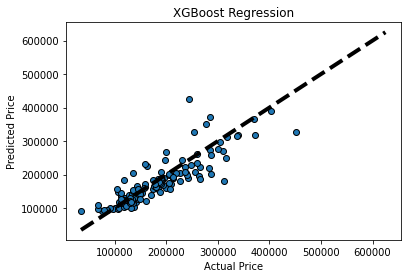

In [73]:
fig, ax = plt.subplots()
ax.scatter(y_test, XGBRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('XGBoost Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

## Voting Regressor

In [74]:
VotingRegression = VotingRegressor(estimators=[('LR', LinearRegressor),("XGBR",XGBRegression),("RF",RandomForestRegression)]).fit(X_train, y_train)
VRprediction     = VotingRegression.predict(X_test)

print("Voting Regression (Train) {}\u00b2 :".format("R"),VotingRegression.score(X_train, y_train))
print("Voting Regression (Test)  {}\u00b2 :".format("R"),VotingRegression.score(X_test, y_test))
print("")
print('Voting Regressor Mean Absolute Error     :', metrics.mean_absolute_error(y_test, VRprediction))
print('Voting Regressor Mean Squared Error      :', metrics.mean_squared_error(y_test, VRprediction))
print('Voting Regressor Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, VRprediction)))

Voting Regression (Train) R² : 0.8576682451512772
Voting Regression (Test)  R² : 0.78917270238107

Voting Regressor Mean Absolute Error     : 22554.41634817144
Voting Regressor Mean Squared Error      : 1105719910.1364813
Voting Regressor Root Mean Squared Error : 33252.36698547159


In [75]:
pd.DataFrame({'Actual': y_test.values.ravel(), 'Predicted': VRprediction})

,Actual,Predicted
0,190000,205336.367475
1,100000,99482.504718
2,115000,114723.234479
3,159000,162975.858894
4,315500,256587.777192
...,...,...
141,132000,120531.129544
142,178000,180897.608146
143,118500,179479.081240
144,145000,159344.522341


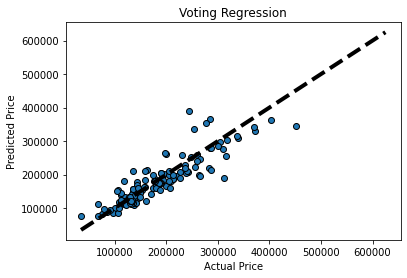

In [76]:
fig, ax = plt.subplots()
ax.scatter(y_test, VRprediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_title('Voting Regression')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()